In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import random
from agent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...
INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face.  Unknown file format.


In [2]:
env = UnityEnvironment(file_name='Env_1_Agent/Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
"""
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
"""

"\nenv_info = env.reset(train_mode=False)[brain_name]     # reset the environment    \nstates = env_info.vector_observations                  # get the current state (for each agent)\nscores = np.zeros(num_agents)                          # initialize the score (for each agent)\nwhile True:\n    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)\n    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1\n    env_info = env.step(actions)[brain_name]           # send all actions to tne environment\n    next_states = env_info.vector_observations         # get next state (for each agent)\n    rewards = env_info.rewards                         # get reward (for each agent)\n    dones = env_info.local_done                        # see if episode finished\n    scores += env_info.rewards                         # update the score (for each agent)\n    states = next_states                               # roll over states to next ti

In [6]:
#definition hyperparameters and trainingsconditions
n_episodes = 500
max_eps= 1.0
min_eps = 0.01
eps_decay = 0.995
training_mode = True

Episode:0 Score:[0.19]


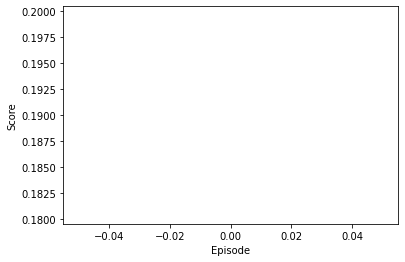

In [7]:
# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = Agent(state_size, action_size, random_seed=0)

#train the agent
def ddpg_train(n_episodes, eps_start, eps_end, eps_decay):

    #list containing scores from each episode
    scores = []
    #last 100 scores
    scores_window = deque(maxlen=100)
    #initialize epsilon
    eps = eps_start
    
    for episode in range(n_episodes): 
        # Reset the enviroment
        env_info = env.reset(train_mode=training_mode)[brain_name] 
        cur_state = env_info.vector_observations
        score= np.zeros(num_agents)
        
        while True:
      
            # Predict the action for the current state.
            # Achtung Epsilon entspricht noch nicht dem wahren Epsilon
            if random.random() < eps:
                # Choose random action
                action = np.random.randn(num_agents, action_size)
                action = np.clip(action, -1, 1)
            else:
                # Choose best action for given network
                action = agent.act(cur_state, add_noise = False)
        
            # Action is performed and new state, reward, info are received. 
            env_info = env.step(action)[brain_name]
        
            # get next state 
            next_state = env_info.vector_observations
            
            # see if episode is finished
            done = env_info.local_done
            
            # get reward
            reward = env_info.rewards 
            
            # current state, action, reward, new state are stored in the experience replay
            agent.step(cur_state, action, reward, next_state, done)
        
            # roll over new state
            cur_state = next_state
            
            #add reward to score
            score += reward 
            
            if np.any(done):
                break
        
        print("Episode:" + str(episode) + " Score:" + str(score))
        
        #decrease epsilon
        eps = max(eps_end, eps_decay*eps)
        
        #save most recent score
        scores_window.append(score)
        scores.append(score)
        
        # save model weights and print mean score over last 100 episodes
        if (episode+1) % 100 == 0:
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_Actor.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode+1, np.mean(scores_window)))
    
    return scores

scores = ddpg_train(n_episodes, max_eps, min_eps, eps_decay)

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [8]:
env.close()